In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from random import sample
from time import time
import sklearn.ensemble as sk
import sklearn.metrics as skm
import pylab as pl
import matplotlib.pyplot as plt

In [4]:
# Data Loading
database ='database.sqlite'
connection = sqlite3.connect(database)
match = pd.read_sql("SELECT * FROM Match;", connection)

In [5]:
#Dropping unwanted NaN rows from the dataset
selectColumns=['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 
                'date',  'country_id', 'league_id', 'season', 'stage']
match.dropna(subset = selectColumns, inplace = True)

In [6]:
# Data Selection
selectColumns=[
               'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','date',
               'country_id','league_id','season','stage','B365H','BWH','IWH','LBH','PSH',
               'B365D','BWD','IWD','LBD','PSD','B365A','BWA','IWA','LBA', 'PSA','home_player_7',
               'away_player_7','home_player_10','home_player_11','away_player_10','away_player_11'
              ]

#Selecting important columns only
mBet=match[selectColumns]

#Converting data values to required format
mBet['date'] = pd.to_datetime(mBet['date'])
mBet = mBet.assign(month=mBet['date'].dt.month)
mBet['date'] = mBet['date'].dt.year
mBet['season']= mBet['season'].str[:4]

# Replacing null values with mean values
mBet['BWH'].fillna(mBet['BWH'].mean(),inplace=True)
mBet['BWA'].fillna(mBet['BWA'].mean(),inplace=True)
mBet['BWD'].fillna(mBet['BWD'].mean(),inplace=True)
mBet['IWH'].fillna(mBet['BWH'].mean(),inplace=True)
mBet['IWA'].fillna(mBet['BWA'].mean(),inplace=True)
mBet['IWD'].fillna(mBet['BWD'].mean(),inplace=True)
mBet['LBH'].fillna(mBet['BWH'].mean(),inplace=True)
mBet['LBA'].fillna(mBet['BWA'].mean(),inplace=True)
mBet['LBD'].fillna(mBet['BWD'].mean(),inplace=True)
mBet['PSH'].fillna(mBet['BWH'].mean(),inplace=True)
mBet['PSA'].fillna(mBet['BWA'].mean(),inplace=True)
mBet['PSD'].fillna(mBet['BWD'].mean(),inplace=True)
mBet['B365H'].fillna(mBet['B365H'].mean(),inplace=True)
mBet['B365A'].fillna(mBet['B365A'].mean(),inplace=True)
mBet['B365D'].fillna(mBet['B365D'].mean(),inplace=True)
mBet.fillna(0,inplace=True)

matchData=mBet

C:\Users\suche\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Creating train, test and validate data from a single data
def train_test_validate_split(dataframe, trainPercent=.7, validatePercent=.15, seed=None):
    # Referred from StackOverflow
    np.random.seed(seed)
    perm = np.random.permutation(dataframe.index)
    length = len(dataframe)
    trainEnd = int(trainPercent * length)
    validateEnd = int(validatePercent * length) + trainEnd
    train = dataframe.ix[perm[:trainEnd]]
    test = dataframe.ix[perm[validateEnd:]]
    validate = dataframe.ix[perm[trainEnd:validateEnd]]
    return train, test, validate

np.random.seed([243])
train, test, validate = train_test_validate_split(matchData)

# Length of all different data
print("Length of Train data %d" %len(train))
print("Length of Test data %d" %len(test))
print("Length of Validate data %d" %len(validate))

Length of Train data 18185
Length of Test data 3898
Length of Validate data 3896


In [8]:
def fullTime(h,a):
    if (h>a) : 
        return "Win"
    elif (h<a) : 
        return "Loss"
    else:
        return "Draw"
# Fetching full time results of the different data sets i.e. Test, Train and Validate
testResult=test.apply(lambda row: fullTime(row['home_team_goal'], row['away_team_goal']), axis=1)
trainResult=train.apply(lambda row: fullTime(row['home_team_goal'], row['away_team_goal']), axis=1)
validateResult=validate.apply(lambda row: fullTime(row['home_team_goal'], row['away_team_goal']), axis=1)

# Deleting goals column from all data, so that we can predict and get desired results
# If we don't remove them, it'll give actual results which will fail our purpose

del train['home_team_goal']
del train['away_team_goal']
del test['home_team_goal']
del test['away_team_goal']
del validate['home_team_goal']
del validate['away_team_goal']

In [9]:
trainResult.value_counts()

Win     8288
Loss    5255
Draw    4642
dtype: int64

In [10]:
# Applying the different classifier's and predicting the results

# clf = neighbors.KNeighborsClassifier(30, weights = 'uniform') 
# Results were validation set = 0.463715 & test set = 0.459407 # Dropper it

#clf=LogisticRegression(random_state=0)
# Results were validation set = 0.520115 & test set = 0.514813

#clf=LogisticRegression(penalty='l1', C=10)
# Results were validation set = 0.522618 & test set = 0.520970 # Not getting desired results, Dropped it

# clf= DecisionTreeClassifier(random_state=100)
# Results were validation set = 0.397690 & test set = 0.402462 # Worst Result

# clf=SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
# Results were validation set = 0.461983 & test set = 0.455175 # Not getting desired results, Dropped it

# Going forward with Random Forest Classfier and more tuning

# When adding different parameters or levers, accuracy kept increasing
# With n_estimators only accuracy was 0.501542 & 0.493981
# When adding oob_score nothing much changed  accuracy was 0.502 & 0.495 but processing time was somewhat faster than before
# When adding random_state accuracy was 0.510491 & 0.495575
# When adding max_features accuracy didn't changed 0.510491 & 0.495575
# When added min_samples_leaf, accuracy made a good gap (atleast for me) from before 0.520693 & 0.514044
# By increasing n_estimators value from 100->1000 (10 Times), processing time increased and better accuracy 0.524350 & 0.530589
# By increasing n_estimators value from 1000->5000 (5 Times), not much difference in accuracy 0.524158 & 0.531743
# but processing time is unacceptably long.





clf = sk.RandomForestClassifier(n_estimators=1000, oob_score = True,random_state =42,max_features = "auto", min_samples_leaf = 50)
model = clf.fit(train, trainResult)

In [11]:
validatePredictions = clf.predict(validate)
print("Calculated mean accuracy score of the Model for validation set = %f" %(clf.score(validate, validateResult)))

testPredictions = clf.predict(test)
print("Calculated mean accuracy score of the Model for test set = %f" %(clf.score(test, testResult)))

Calculated mean accuracy score of the Model for validation set = 0.518480
Calculated mean accuracy score of the Model for test set = 0.527193


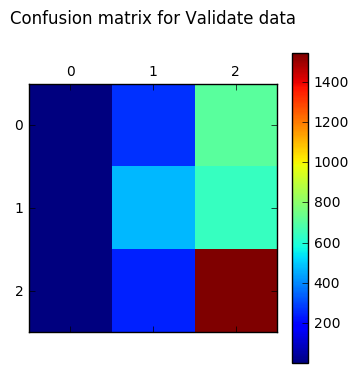

Prediction of Validate data


Predicted Results,Draw,Loss,Win
Actual Results,,,
Draw,2,271,711
Loss,4,476,640
Win,2,248,1542


In [12]:
theResultofValidate = skm.confusion_matrix(validateResult,validatePredictions)
pl.matshow(theResultofValidate)
pl.title('Confusion matrix for Validate data\n\n')
pl.colorbar()
pl.show()
print('Prediction of Validate data')
pd.crosstab(validateResult, validatePredictions, rownames=['Actual Results'], colnames=['Predicted Results'])

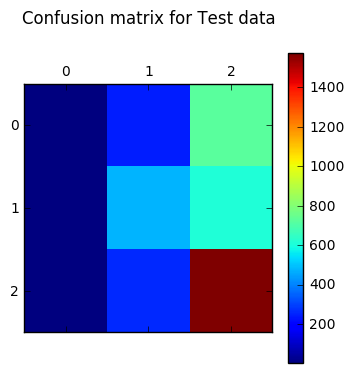

Prediction of Test data


Predicted Results,Draw,Loss,Win
Actual Results,,,
Draw,3,244,723
Loss,3,478,610
Win,2,261,1574


In [13]:
theResultofTest = skm.confusion_matrix(testResult,testPredictions)
pl.matshow(theResultofTest)
pl.title('Confusion matrix for Test data\n\n')
pl.colorbar()
pl.show()
print('Prediction of Test data')
pd.crosstab(testResult, testPredictions, rownames=['Actual Results'], colnames=['Predicted Results'])